## Filtering with SWE --- "immersed bump" example
*Connor Duffin*


In [17]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.insert(0, "../src")
from figures import figure_sizes

from pyDOE import lhs
from scipy.linalg import cho_factor, cho_solve
from statfenics.utils import build_observation_operator
from swe import ShallowOne, ShallowOneLinear
from swe_filter import ShallowOneKalman, ShallowOneEx
from tqdm import tqdm

np.random.seed(28)

In [18]:
def compute_rmse(post, y_obs, H_obs):
    """ Compute the error norm. Computed on a regular grid. """
    y_post = H_obs @ post.mean
    return norm(y_post - y_obs) / np.sqrt(len(y_obs))


def compute_pp(H, swe_post): 
    mean_obs = H @ swe_post.mean 
    HL = H @ swe_post.cov_sqrt
    cov_obs = HL @ HL.T
    cov_obs[np.diag_indices_from(cov_obs)] += sigma_y**2 + 1e-10
    return mean_obs, cov_obs


def compute_coverage(y, mean , cov):
    lower = mean - 1.96 * np.sqrt(cov.diagonal())
    upper = mean + 1.96 * np.sqrt(cov.diagonal())
    return ((y > lower) & (y < upper)).sum() / nx_obs

In [19]:
norm = np.linalg.norm

NX = 500
DT = 1.
THETA = 0.6
NU = 1.

k = 32
sigma_y = 5e-2

# set the observation system
t_final = 4. * 60 * 60.
t_grid = np.arange(0., t_final, DT)

nt = np.int64(t_final / DT)
nt_skip = 30
nt_obs = len([i for i in range(nt) if i % nt_skip == 0])

control = dict(nx=NX, dt=DT, theta=THETA, simulation="tidal_flow")
params = dict(nu=NU, 
              shore_start=2000., shore_height=5.,
              bump_height=0., bump_centre=8000., bump_width=1000)
stat_params = dict(rho_u=0., ell_u=1000.,
                   rho_h=5e-4, ell_h=1000.,
                   k=k, k_init_u=k, k_init_h=k,
                   hilbert_gp=True)

swe_post_ex = ShallowOneEx(
    control=control,
    params=params,
    stat_params=stat_params,
    lr=True)
print(f"Assimilating every {nt_skip} timesteps ({nt_skip * swe_post_ex.dt:.3f} s)")
print(f"Observational noise has std. dev. {sigma_y:.4e}")

Spectral diff (h): 5.9850e-26, 5.9648e-04
Assimilating every 30 timesteps (30.000 s)
Observational noise has std. dev. 5.0000e-02


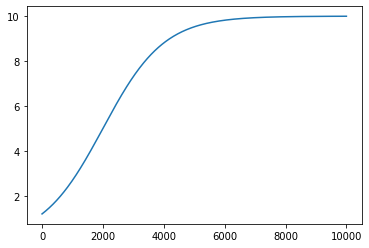

In [20]:
fe.plot(30 - swe_post_ex.H)
plt.show()

In [21]:
dat = xr.open_dataset("../data/h_shore.nc")

# do some double checking
assert DT == dat.coords["t"].values[1] - dat.coords["t"].values[0]

# build observation/interpolation operators
nx_obs = 1
idx_obs = np.linspace(50, 100, nx_obs, dtype="int")
x_obs = dat.coords["x"].values[idx_obs][:, np.newaxis]
nx_obs = len(x_obs)

y_obs = dat["h"].values[1:, idx_obs]  # dont include IC

print(x_obs.shape)
print(y_obs.shape)
dat.close()

H_obs = build_observation_operator(x_obs, swe_post_ex.W, sub=1, out="scipy")
H_u_verts = build_observation_operator(swe_post_ex.x_coords, swe_post_ex.W, sub=0)
H_h_verts = build_observation_operator(swe_post_ex.x_coords, swe_post_ex.W, sub=1)

(1, 1)
(86400, 1)


In [22]:
coverage = np.zeros((nt_obs, ))
means_obs = np.zeros((nt_obs, nx_obs))
covs_obs = np.zeros((nt_obs, nx_obs, nx_obs))

rmse_ex = np.zeros((nt_obs, ))
lml_ex = np.zeros((nt_obs, ))

t = 0.
i_save = 0

t_nearest_plot = 3 * t_final / 4
n_nearest_plot = np.int64(np.round(t_nearest_plot / DT))
n_plot = n_nearest_plot - (n_nearest_plot % nt_skip)
for i in range(nt):
    t += swe_post_ex.dt
    swe_post_ex.prediction_step(t)
    
    if i % nt_skip == 0:
        lml_ex[i_save] = swe_post_ex.compute_lml(y_obs[i, :], H_obs, sigma_y)
        swe_post_ex.update_step(y_obs[i, :], H_obs, sigma_y)
        
        rmse_ex[i_save] = compute_rmse(swe_post_ex, y_obs[i, :], H_obs)
        
        means_obs[i_save, :], covs_obs[i_save, :, :] = compute_pp(H_obs, swe_post_ex)
        coverage[i_save] = compute_coverage(y_obs[i, :],
                                            means_obs[i_save, :],
                                            covs_obs[i_save, :, :])
        
        coverage_rolling_mean = np.mean(coverage[:(i_save + 1)])
        print(f"\r Iteration {i} of {nt}, Coverage = {coverage_rolling_mean:.4e}", end="")
        i_save += 1
        
    if i % n_plot == 0:
        assert i % nt_skip == 0
        # data
        y_plot = y_obs[i, :]

        # nonlinear
        u_mean_ex, h_mean_ex = swe_post_ex.get_vertex_values()
        var_u_ex = np.sum((H_u_verts @ swe_post_ex.cov_sqrt)**2, axis=1)
        var_h_ex = np.sum((H_h_verts @ swe_post_ex.cov_sqrt)**2, axis=1)
        
    swe_post_ex.set_prev()

 Iteration 14370 of 14400, Coverage = 9.5833e-01

In [24]:
print(f'{np.sum(lml_ex):.4e}')

-9.3523e+04


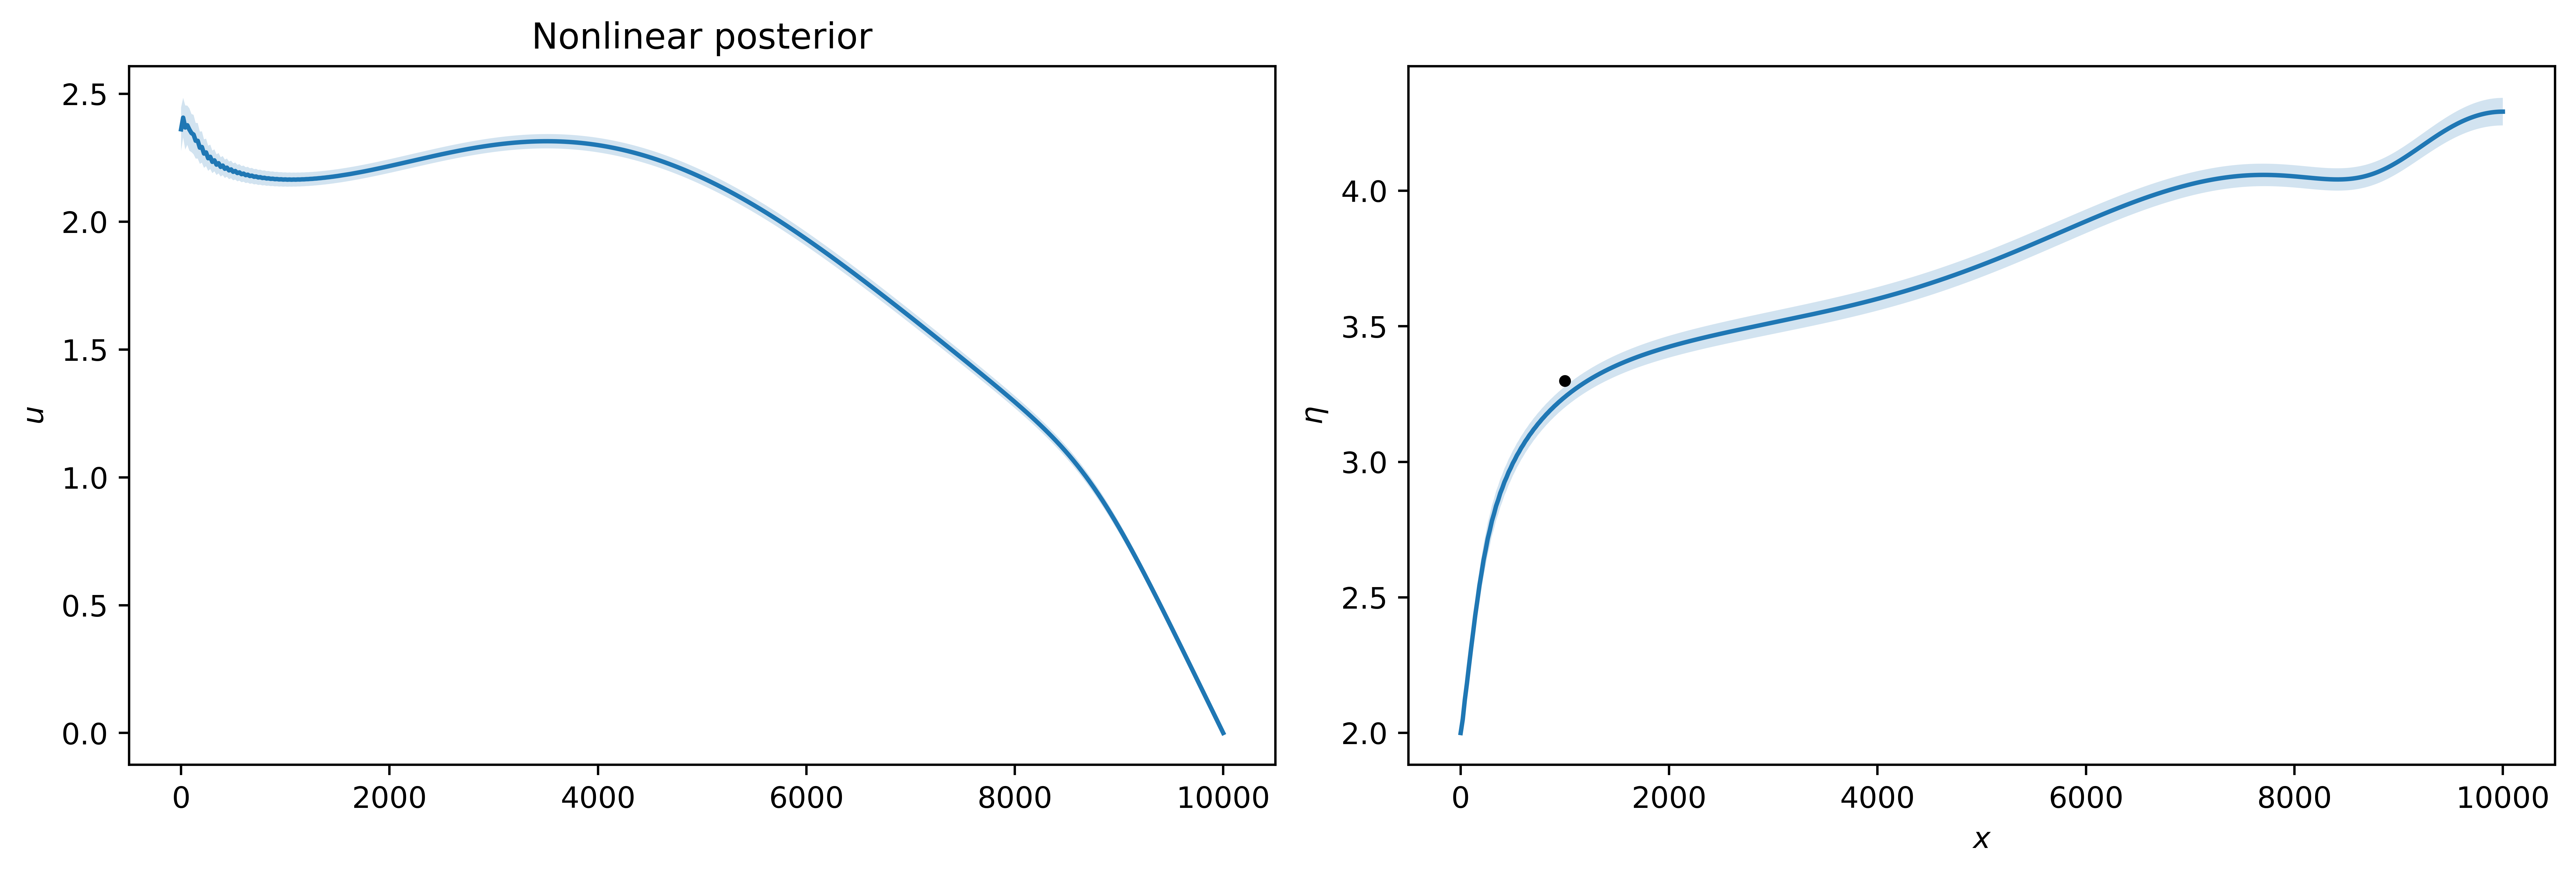

In [25]:
fig, axs = plt.subplots(1, 2, 
                        constrained_layout=True, 
                        figsize=(12, 4), 
                        sharey=False, 
                        sharex=True,
                        dpi=700)
axs = axs.flatten()

# velocities
x_grid = swe_post_ex.x_coords
axs[0].plot(x_grid, u_mean_ex)
axs[0].fill_between(x_grid[:, 0], 
                    u_mean_ex - 1.96 * np.sqrt(var_u_ex), u_mean_ex + 1.96 * np.sqrt(var_u_ex),
                    alpha=0.2)
axs[0].set_ylabel(r"$u$")
axs[0].set_title(r"Nonlinear posterior")

axs[1].plot(x_obs, y_plot, ".", color="black")
axs[1].plot(x_grid, h_mean_ex, label="Posterior")
axs[1].fill_between(x_grid[:, 0], 
                    h_mean_ex - 1.96 * np.sqrt(var_h_ex), h_mean_ex + 1.96 * np.sqrt(var_h_ex),
                    alpha=0.2)
axs[1].set_ylabel(r"$\eta$")
axs[1].set_xlabel(r"$x$")
plt.show()

Now we check, in the meantime, to make sure that a quicker variance calculation works out OK:

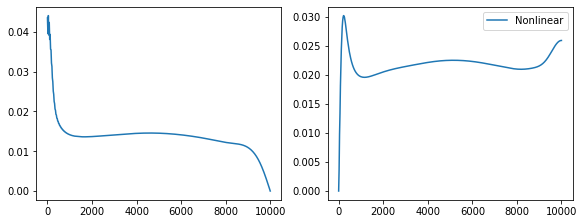

In [26]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3))
axs[0].plot(swe_post_ex.x_coords, np.sqrt(var_u_ex))
axs[1].plot(swe_post_ex.x_coords, np.sqrt(var_h_ex), label="Nonlinear")
axs[1].legend()
plt.show()

Next we plot the relative errors and we see that they look OK:

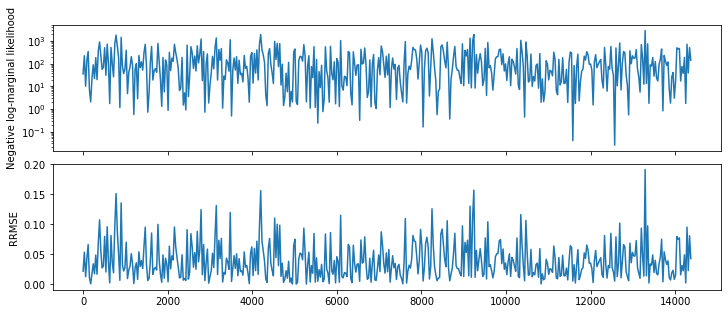

In [38]:
fig, ax = plt.subplots(2, 1,  
                       constrained_layout=True, 
                       figsize=(10, 4),
                       sharex=True)
ax[0].semilogy(t_grid[::nt_skip], np.abs(lml_ex), label="Nonlinear")
ax[0].set_ylabel("Negative log-marginal likelihood")
ax[1].plot(t_grid[::nt_skip], rmse_ex, label="Nonlinear RMSE")
ax[1].set_ylabel("RRMSE")
plt.show()

In [39]:
print(np.mean(rmse_ex))

0.03887238654744277


Next, we look at the prediction means and variances

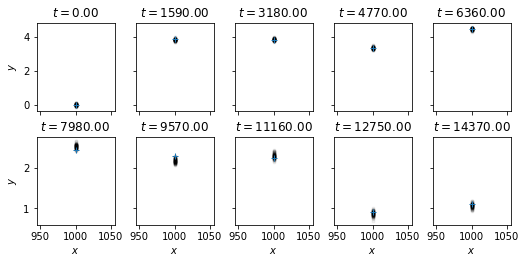

In [40]:
time_indices = np.int64(np.linspace(0, nt_obs - 1, 10), )
fig, axs = plt.subplots(2, 5, constrained_layout=True, 
                        figsize=(figure_sizes["fullwidth"], figure_sizes["halfwidth"]),
                        sharex=True, sharey="row")

for ax in axs[1, :]: ax.set_xlabel(r"$x$")
for ax in axs[:, 0]: ax.set_ylabel(r"$y$")

axs = axs.flatten()
for i, idx in enumerate(time_indices):
    mean = means_obs[idx, :]
    cov = covs_obs[idx, :]
    y = y_obs[nt_skip * idx, :]
    samples = np.random.multivariate_normal(mean=mean, cov=cov, size=100)
    
    axs[i].set_title(fr"$t = {t_grid[nt_skip * idx]:.2f}$")
    axs[i].plot(x_obs, samples.T, ".", alpha=0.05, color="black")
    axs[i].plot(x_obs, y, "+")

plt.savefig("../figures/y-pred.png", dpi=600)

0.9583333333333334


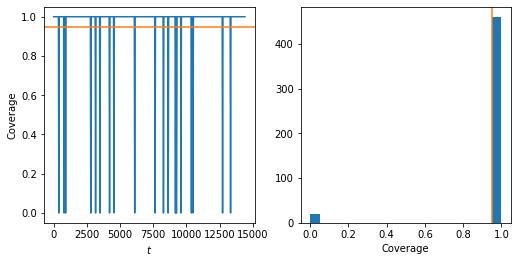

In [30]:
print(np.mean(coverage))

fig, ax = plt.subplots(1, 2, constrained_layout=True,
                      figsize=(2 * figure_sizes["halfwidth"], figure_sizes["halfwidth"]))
ax[0].plot(np.linspace(0, t_final, len(coverage)), coverage)
ax[0].axhline(y=0.95, color="tab:orange")
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"Coverage")

ax[1].hist(coverage, bins=20)
ax[1].axvline(x=0.95, color="tab:orange")
ax[1].set_xlabel("Coverage")
plt.savefig("../figures/y-pred-coverage.pdf", dpi=600)
plt.show()